In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import os

import torch

import warnings
warnings.filterwarnings("ignore") 

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [3]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

data_1 = data[data['loan_status'] == 1]

In [4]:
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/train/train_OI_11_00_fake.csv"
fake = pd.read_csv(fake_path)
fake['loan_status'] = 1

## Data Î∂ÑÏÑù

In [5]:
data.describe()

last_fico_range_high  mo_sin_old_rev_tl_op      int_rate    annual_inc  \
count          1.488611e+06          1.488611e+06  1.488611e+06  1.488611e+06   
mean           6.789315e+02          1.806540e+02  1.316708e-01  7.739155e+04   
std            8.248265e+01          9.403798e+01  4.828138e-02  1.266082e+05   
min            0.000000e+00          1.000000e+00  5.310000e-02  0.000000e+00   
25%            6.290000e+02          1.180000e+02  9.490000e-02  4.600000e+04   
50%            6.940000e+02          1.670000e+02  1.269000e-01  6.500000e+04   
75%            7.390000e+02          2.270000e+02  1.599000e-01  9.200000e+04   
max            8.500000e+02          9.090000e+02  3.099000e-01  1.100000e+08   

                dti      zip_code   installment  fico_range_low  \
count  1.488611e+06  1.488611e+06  1.488611e+06    1.488611e+06   
mean   1.856865e+01  5.133410e+02  4.402160e+02    6.976665e+02   
std    1.308961e+01  3.116710e+02  2.668187e+02    3.270163e+01   
min   -1.000000e+00  7.000000e+00  4.930000e+00    6.250000e+02   
25%    1.183000e+01  2.330000e+02  2.469900e+02    6.700000e+02   
50%    1.773000e+01  4.800000e+02  3.736300e+02    6.900000e+02   
75%    2.429000e+01  8.020000e+02  5.849100e+02    7.150000e+02   
max    9.990000e+02  9.990000e+02  1.719830e+03    8.450000e+02   

       total_rev_hi_lim   avg_cur_bal  bc_open_to_buy    revol_util  \
count      1.488611e+06  1.488611e+06    1.488611e+06  1.488611e+06   
mean       3.382528e+04  1.357406e+04    1.106934e+04  5.046413e-01   
std        3.456132e+04  1.613242e+04    1.605042e+04  2.477235e-01   
min        0.000000e+00  0.000000e+00    0.000000e+00  0.000000e+00   
25%        1.470000e+04  3.191000e+03    1.731000e+03  3.160000e-01   
50%        2.580000e+04  8.013000e+03    5.588000e+03  5.050000e-01   
75%        4.120000e+04  1.826700e+04    1.313400e+04  6.950000e-01   
max        9.999999e+06  9.580840e+05    6.059960e+05  8.923000e+00   

          revol_bal     total_acc  credit_history_years   loan_status  
count  1.488611e+06  1.488611e+06          1.488611e+06  1.488611e+06  
mean   1.628444e+04  2.461144e+01          1.630636e+01  1.950711e-01  
std    2.230701e+04  1.205241e+01          7.590675e+00  3.962556e-01  
min    0.000000e+00  2.000000e+00          3.000000e+00  0.000000e+00  
25%    5.850000e+03  1.600000e+01          1.100000e+01  0.000000e+00  
50%    1.107600e+04  2.300000e+01          1.500000e+01  0.000000e+00  
75%    1.977800e+04  3.100000e+01          2.000000e+01  0.000000e+00  
max    2.568995e+06  1.760000e+02          8.300000e+01  1.000000e+00

In [6]:
data_1.describe()

last_fico_range_high  mo_sin_old_rev_tl_op       int_rate  \
count         290385.000000         290385.000000  290385.000000   
mean             570.513697            170.771984       0.156564   
std               55.708222             94.701712       0.050233   
min                0.000000              1.000000       0.053100   
25%              524.000000            108.000000       0.120500   
50%              564.000000            155.000000       0.149900   
75%              604.000000            215.000000       0.185500   
max              850.000000            842.000000       0.309900   

         annual_inc            dti       zip_code    installment  \
count  2.903850e+05  290385.000000  290385.000000  290385.000000   
mean   7.205912e+04      20.262582     505.722386     472.827881   
std    2.159134e+05      13.963821     309.564146     268.404487   
min    0.000000e+00       0.000000       7.000000      21.620000   
25%    4.400000e+04      13.290000     229.000000     277.480000   
50%    6.000000e+04      19.600000     462.000000     407.360000   
75%    8.500000e+04      26.310000     799.000000     621.180000   
max    1.100000e+08     999.000000     999.000000    1717.630000   

       fico_range_low  total_rev_hi_lim    avg_cur_bal  bc_open_to_buy  \
count   290385.000000      2.903850e+05  290385.000000   290385.000000   
mean       689.661312      3.007388e+04   11168.481880     8686.529981   
std         27.311029      2.864216e+04   13483.562844    13058.068718   
min        660.000000      0.000000e+00       0.000000        0.000000   
25%        670.000000      1.360000e+04    2828.000000     1360.000000   
50%        685.000000      2.340000e+04    6028.000000     4324.000000   
75%        705.000000      3.680000e+04   14539.000000    11065.920936   
max        845.000000      1.998700e+06  391669.000000   447887.000000   

          revol_util     revol_bal      total_acc  credit_history_years  \
count  290385.000000  2.903850e+05  290385.000000         290385.000000   
mean        0.529467  1.526658e+04      24.230091             15.735107   
std         0.242278  1.892493e+04      12.170458              7.572991   
min         0.000000  0.000000e+00       2.000000              3.000000   
25%         0.350000  5.843000e+03      15.000000             11.000000   
50%         0.534000  1.095300e+04      22.000000             14.000000   
75%         0.715000  1.899800e+04      31.000000             19.000000   
max         3.666000  1.746716e+06     176.000000             83.000000   

       loan_status  
count     290385.0  
mean           1.0  
std            0.0  
min            1.0  
25%            1.0  
50%            1.0  
75%            1.0  
max            1.0

In [7]:
fake.describe()

last_fico_range_high  mo_sin_old_rev_tl_op       int_rate  \
count         900000.000000         900000.000000  900000.000000   
mean             566.737333            168.829416       0.156591   
std               55.290621             95.142960       0.049031   
min              499.000000              2.000000       0.054200   
25%              519.000000            101.000000       0.122900   
50%              559.000000            153.000000       0.150100   
75%              604.000000            214.000000       0.184900   
max              809.000000            692.000000       0.309900   

          annual_inc            dti       zip_code    installment  \
count  900000.000000  900000.000000  900000.000000  900000.000000   
mean    81969.180700      21.520608     504.303397     474.716145   
std     62595.100085       9.543976     314.741144     264.107725   
min        50.000000       0.230000      10.000000      22.790000   
25%     34528.000000      15.130000     222.000000     282.780000   
50%     66306.000000      20.510000     462.000000     418.390000   
75%    113868.000000      26.520000     826.000000     622.290000   
max    546000.000000     144.300000     998.000000    1664.570000   

       fico_range_low  total_rev_hi_lim    avg_cur_bal  bc_open_to_buy  \
count   900000.000000     900000.000000  900000.000000   900000.000000   
mean       693.897372      32869.283740   10699.238808     8571.668529   
std         27.398070      27566.570441   12622.248858    12637.003778   
min        660.000000       1100.000000      87.000000       47.000000   
25%        675.000000      16650.000000    3121.000000     1854.000000   
50%        690.000000      25200.000000    5818.000000     3832.000000   
75%        705.000000      39585.000000   13582.000000     9636.000000   
max        840.000000     741600.000000  248688.000000   267489.000000   

          revol_util      revol_bal      total_acc  credit_history_years  \
count  900000.000000  900000.000000  900000.000000         900000.000000   
mean        0.520088   15191.367654      24.048742             15.765286   
std         0.239842   15798.348573      12.162327              7.609162   
min         0.001000      44.000000       3.000000              4.000000   
25%         0.341000    6838.000000      15.000000             11.000000   
50%         0.524000   11543.000000      22.000000             14.000000   
75%         0.707000   18713.000000      31.000000             19.000000   
max         1.250000  654134.000000     113.000000             67.000000   

       loan_status  
count     900000.0  
mean           1.0  
std            0.0  
min            1.0  
25%            1.0  
50%            1.0  
75%            1.0  
max            1.0

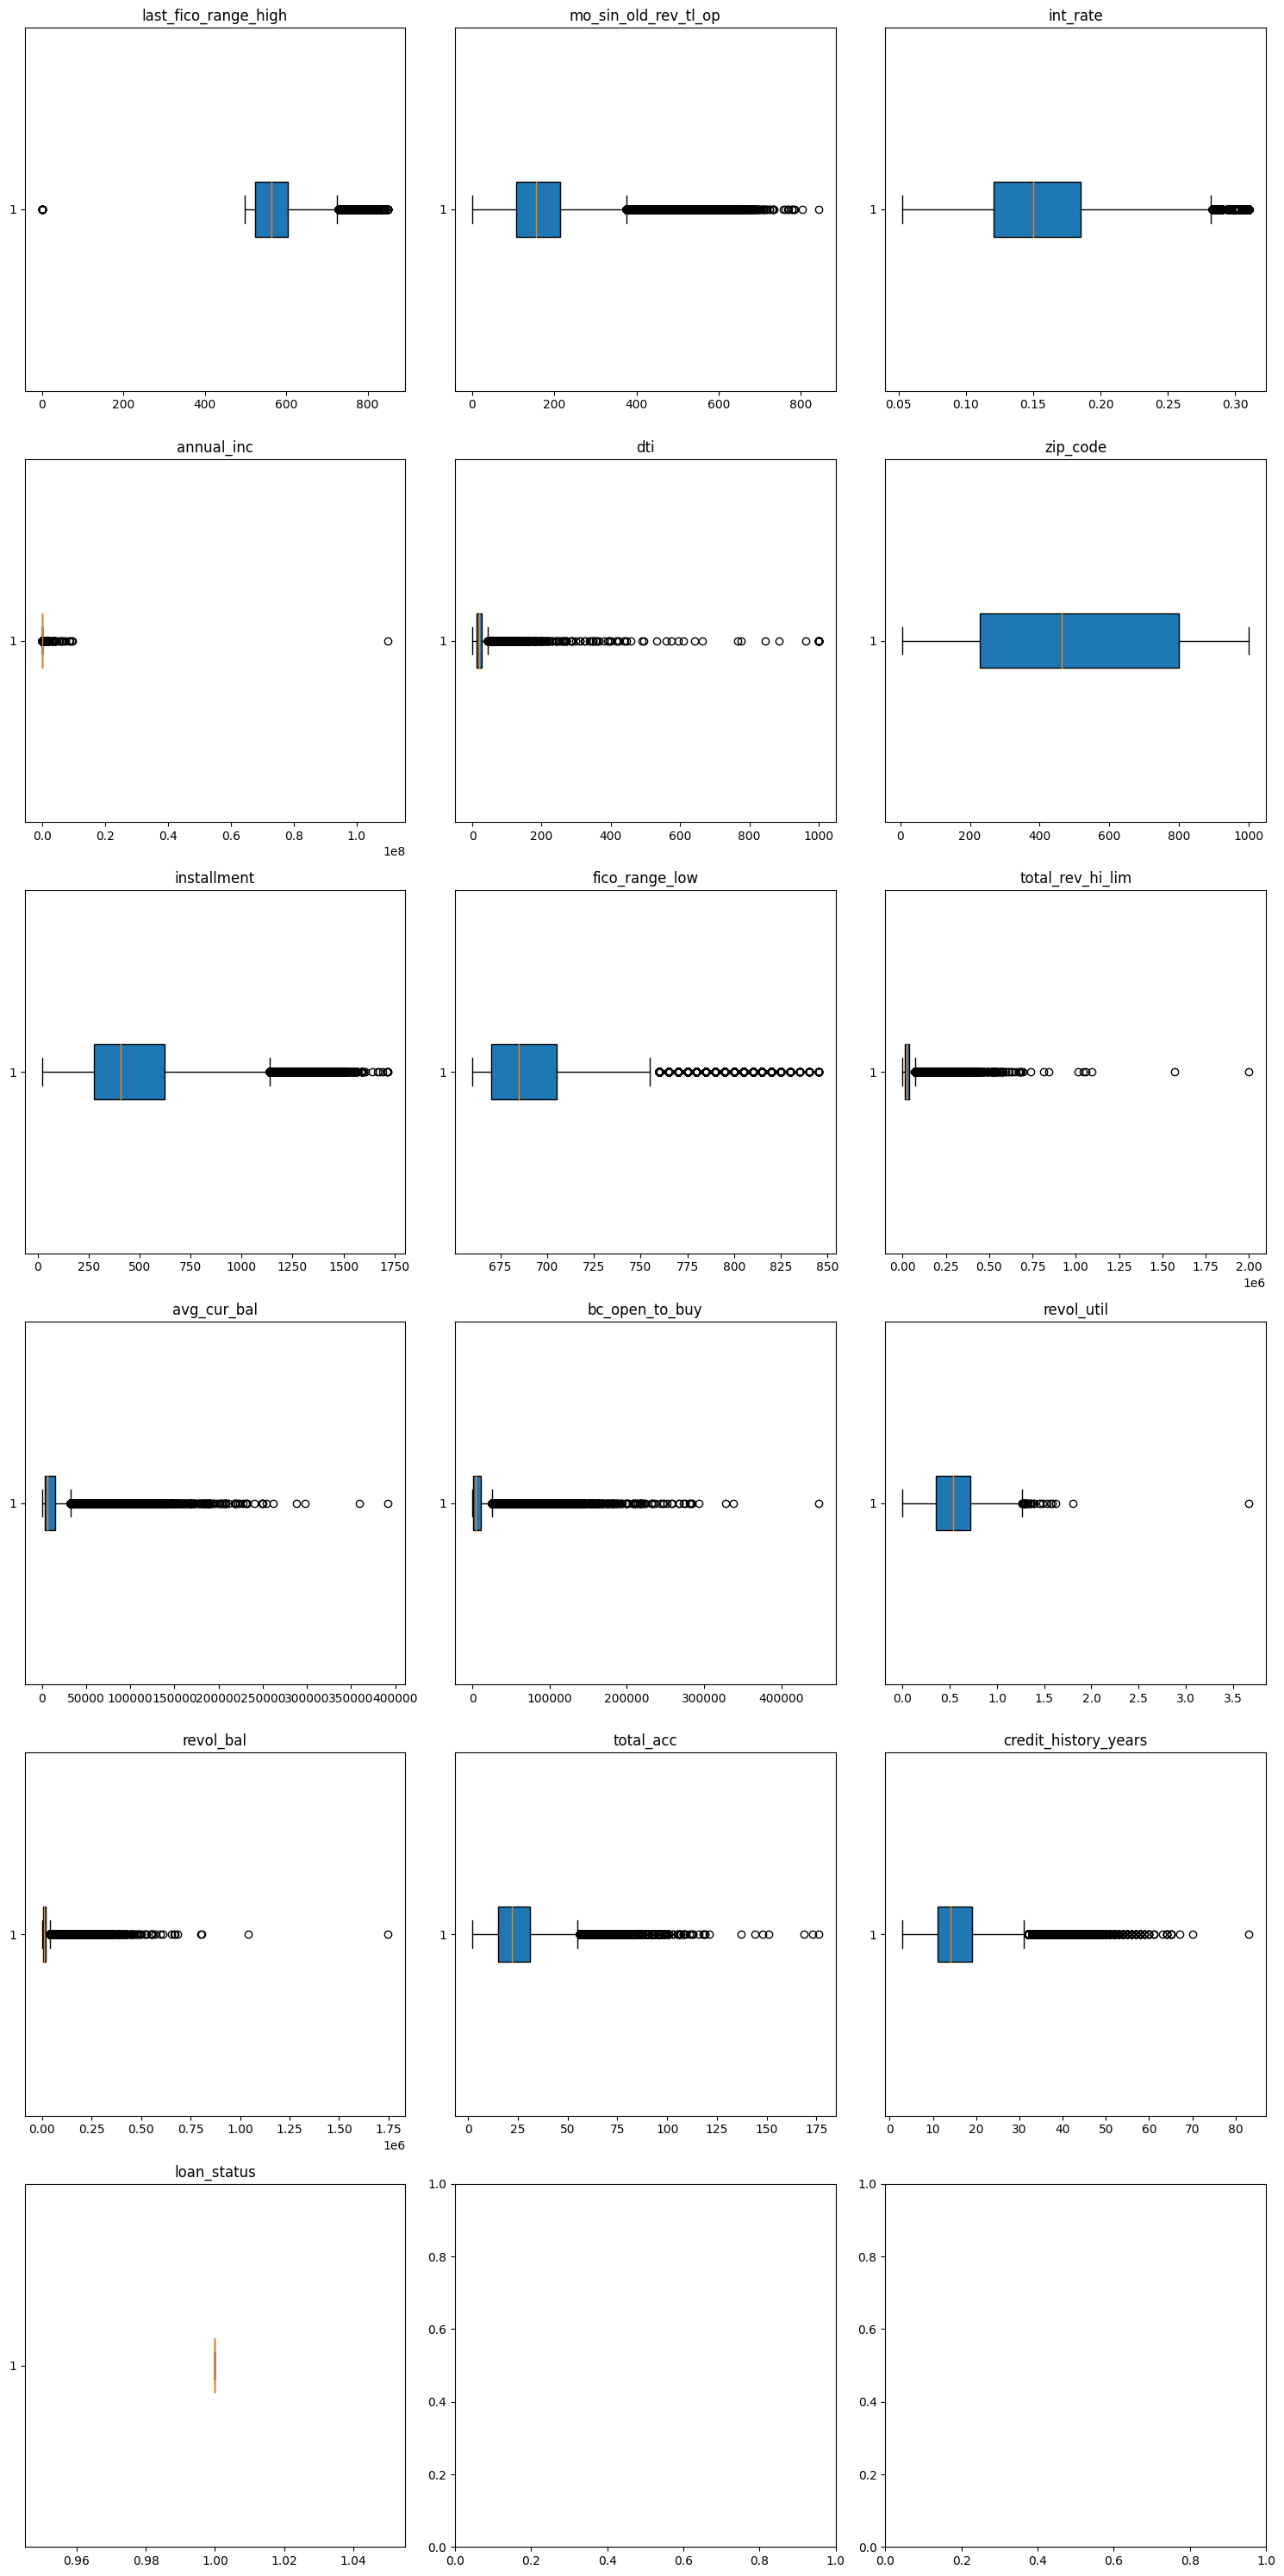

In [8]:
## data Class 1 Correlation
numerical_columns = data_1.select_dtypes(include=[np.number]).columns

# üîπ Boxplot ÏãúÍ∞ÅÌôî (Ïù¥ÏÉÅÏπò ÌôïÏù∏)
fig, axes = plt.subplots(nrows=len(numerical_columns)//3 + 1, ncols=3, figsize=(15, 5 * (len(numerical_columns)//3 + 1)))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    axes[i].boxplot(data_1[col].dropna(), vert=False, patch_artist=True)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

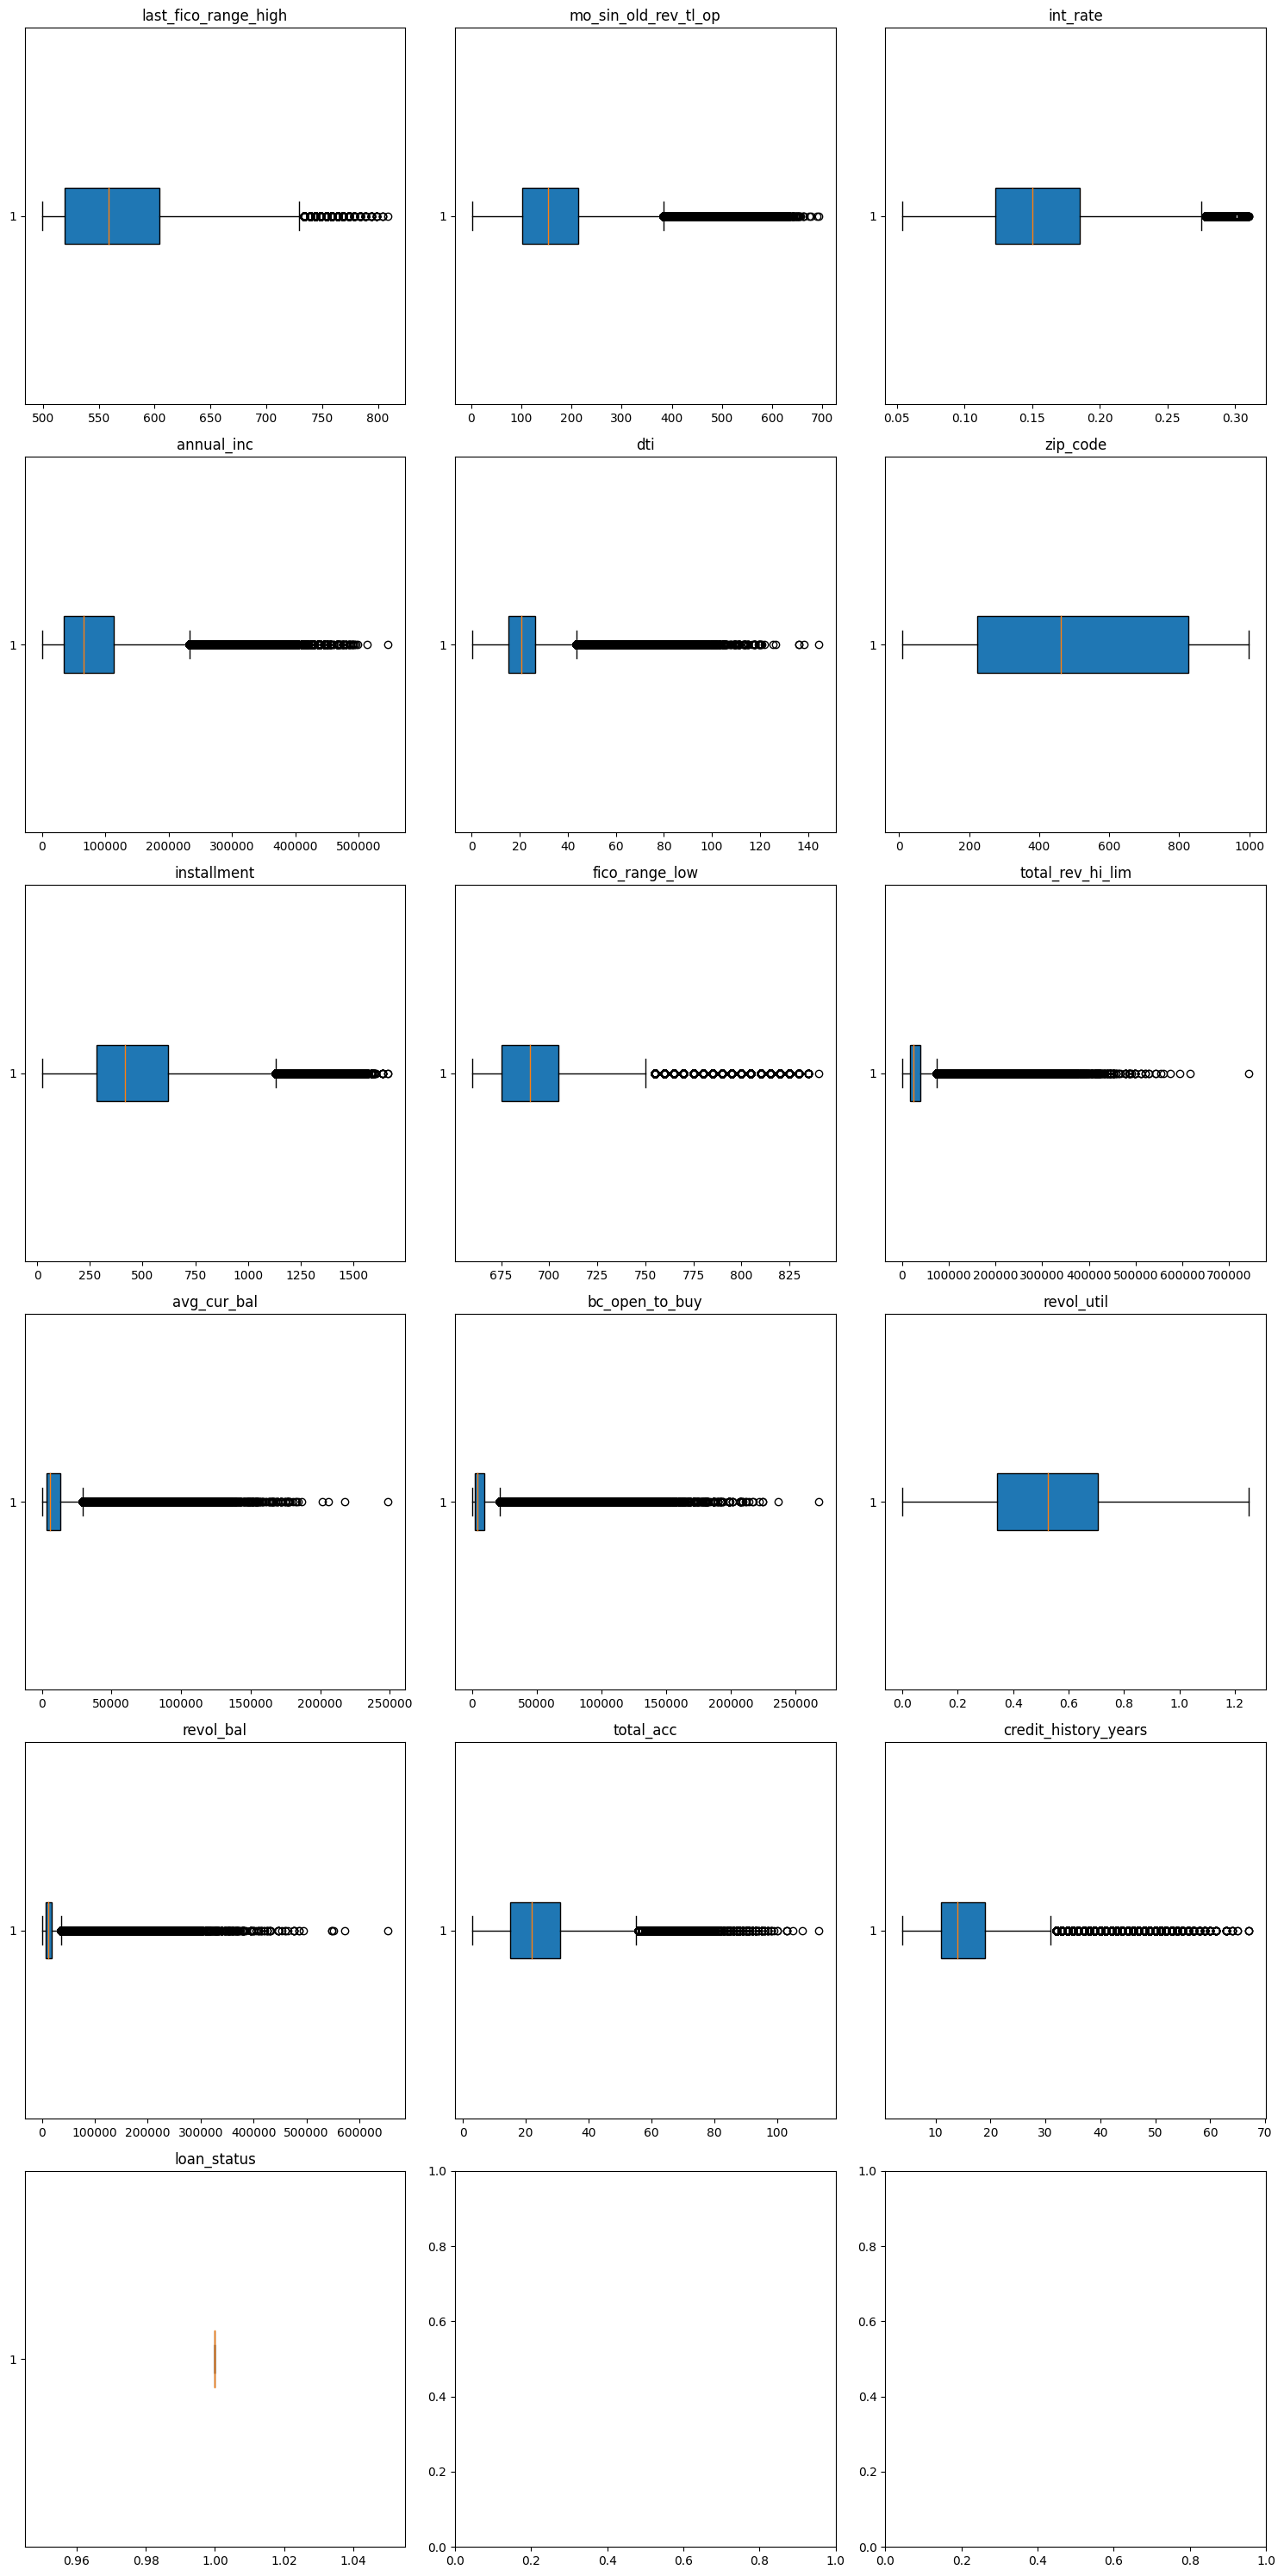

In [9]:
## data Class 1 Correlation
numerical_columns = fake.select_dtypes(include=[np.number]).columns

# üîπ Boxplot ÏãúÍ∞ÅÌôî (Ïù¥ÏÉÅÏπò ÌôïÏù∏)
fig, axes = plt.subplots(nrows=len(numerical_columns)//3 + 1, ncols=3, figsize=(15, 5 * (len(numerical_columns)//3 + 1)))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    axes[i].boxplot(fake[col].dropna(), vert=False, patch_artist=True)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

## Fake data Original data histplot ÎπÑÍµê

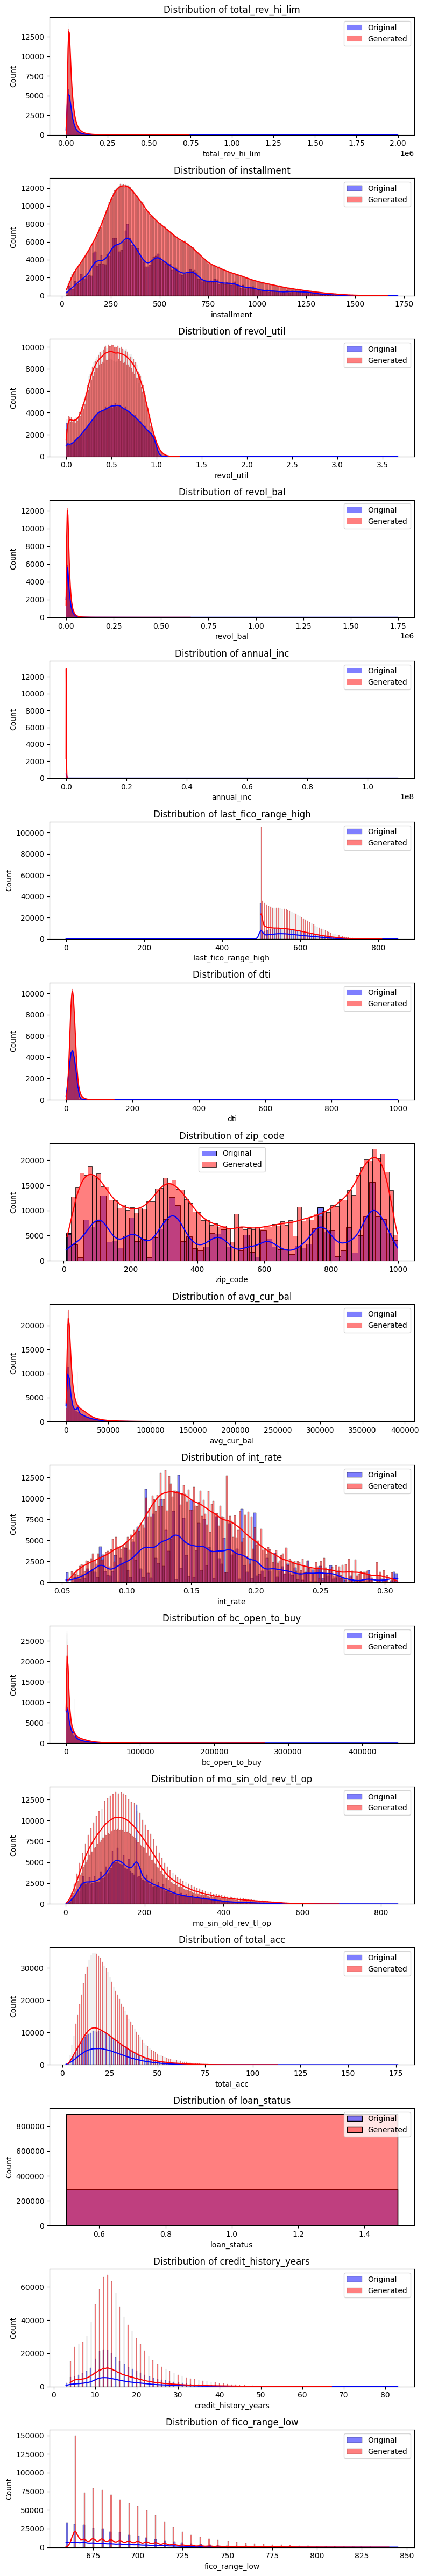

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ÏôÄ TableGAN ÏÉùÏÑ± Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
# ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞: original_df
# TableGANÏù¥ ÏÉùÏÑ±Ìïú Îç∞Ïù¥ÌÑ∞: generated_df

# Í≥µÌÜµ feature ÏÑ†ÌÉù (ÌòπÏãú Ïª¨ÎüºÏù¥ Îã§Î•º ÏàòÎèÑ ÏûàÏúºÎãà)
common_features = list(set(data.columns) & set(fake.columns))
original_df = data_1[common_features]
generated_df = fake[common_features]

# ------------------------------
# 1Ô∏è‚É£ ÌûàÏä§ÌÜ†Í∑∏Îû® ÎπÑÍµê (Í∞Å feature Î∂ÑÌè¨)
# ------------------------------
num_features = len(common_features)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, num_features * 3))

for i, feature in enumerate(common_features):
    sns.histplot(original_df[feature], color='blue', label='Original', kde=True, ax=axes[i], alpha=0.5)
    sns.histplot(generated_df[feature], color='red', label='Generated', kde=True, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].legend()

plt.tight_layout()
plt.show()